# kitti dataset exploration
This notebook apply stereo depth estimation and multiple view geometry to track vehicle position through a sequencee of the images from kitti dataset.

First, let's get the ground truth trajectory

In [29]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv

load_dotenv()

poses = pd.read_csv(os.getenv("poses_file"), delimiter=' ', header=None)
poses.head().round(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.00000,0.00000,0.00000,0.00000,0.00000,1.0,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,0.99998,0.00050,-0.00638,-0.00460,-0.00050,1.0,0.00031,-0.00200,0.00638,-0.00031,0.99998,0.09154
2,0.99991,0.00106,-0.01341,-0.01001,-0.00106,1.0,0.00021,-0.00436,0.01341,-0.00020,0.99991,0.18574
3,0.99978,0.00139,-0.02093,-0.01753,-0.00140,1.0,-0.00040,-0.00686,0.02093,0.00043,0.99978,0.28347
4,0.99955,0.00203,-0.03008,-0.02863,-0.00208,1.0,-0.00179,-0.00673,0.03008,0.00185,0.99955,0.38731


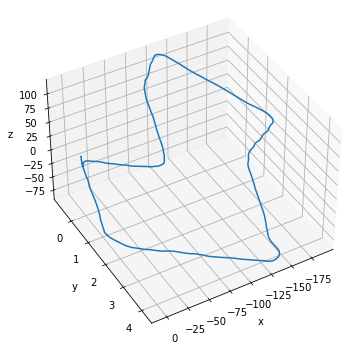

In [2]:
gt: np.ndarray = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))


fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40, azim=60)

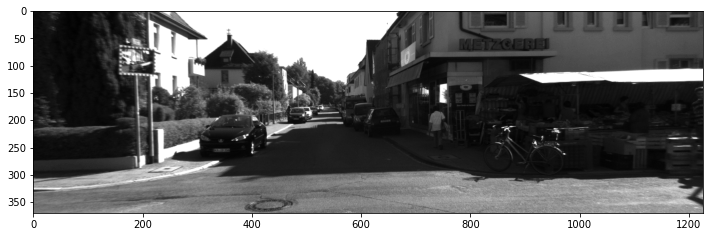

In [3]:
image = plt.imread(os.path.join(os.getenv("l_image_dir"), f"{'0'*10}.png"))
plt.figure(figsize=(12,6))
plt.imshow(image, cmap='gray')
plt.show()

## Camera Projection and Calibration


In [4]:
calib = pd.read_csv(os.getenv("calib_file") , delimiter=' ', header=None, index_col=0)
calib.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,707.091200,0.000000,601.88730,0.000000,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,707.091200,0.000000,601.88730,-379.814500,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,707.091200,0.000000,601.88730,46.887830,0.000000,707.091200,183.110400,0.117860,0.000000,0.000000,1.000000,0.006203
P3:,707.091200,0.000000,601.88730,-333.459700,0.000000,707.091200,183.110400,1.930130,0.000000,0.000000,1.000000,0.003318
Tr:,-0.001858,-0.999966,-0.00804,-0.004784,-0.006481,0.008052,-0.999947,-0.073374,0.999977,-0.001806,-0.006496,-0.333997


In calibration file, we can obtain four `3x4` projection matrices for four position camera: `p0`, `p1`, `p2` and `p3`. And we can also obtain the transformation matrix for the LiDAR that denoted as `Tr`.

<div align='center'>
    <img src="../assets/kitti_schematic.png" width='600' alt='stereo' />
</div>

In [5]:

p0: np.ndarray = np.array(calib.loc['P0:']).reshape((3, 4))
p0

array([[707.0912,   0.    , 601.8873,   0.    ],
       [  0.    , 707.0912, 183.1104,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

A projection matrix project three dimensional cooridnates in the global coordinates (world coordinates) onto two dimensional image plane (pixel coordinate)

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{\lambda}P
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix}
$$

where $\lambda$ is known as the scale, which is the depth to the point along z-axis from the camera. The projection matrix `P` is the dot product of intrinsic matrix and extrinsic matrix. The intrinsic matrix `K` that describe the focal length and optical center parameters of camera, and the extrinsic matrix is the augmented matrix of rotation matrix and translation vector that describe the transformation between world coordinates and camera coordinates

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{\lambda}P
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix} = \frac{1}{\lambda}K[R|t]
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix}
$$

In [6]:
p1: np.ndarray = np.array(calib.loc['P1:']).reshape((3, 4))

k1, r1, t1, *_ = cv2.decomposeProjectionMatrix(p1)
t1 = (t1 / t1[3]).round(3)
print(f"Intrinsic Matrix:\n{k1}\n")
print(f"Rotation Matrix:\n{r1}\n")
print(f"Translation Vector:\n{t1}")

Intrinsic Matrix:
[[707.0912   0.     601.8873]
 [  0.     707.0912 183.1104]
 [  0.       0.       1.    ]]

Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Translation Vector:
[[ 0.537]
 [-0.   ]
 [ 0.   ]
 [ 1.   ]]


In [7]:
Rt: np.ndarray = np.hstack([r1, t1[:3]])
o: np.ndarray = np.array([0, 0, 0, 1])
(Rt @ o).reshape(-1, 1).round(3)

array([[0.537],
       [0.   ],
       [0.   ]])

## Dataset Handler
Implement the dataset handler to manipulate the dataset from files, and make it more accessible to complete our mission.

## Stereo Depth Estimation



<div align='center'>
    <img src="https://github.com/KoKoLates/kitti-dataset-visualize/blob/vo-dev/assets/stereo.png" width='300' alt='stereo' />
</div>

With similar triangles, we can derive as following:

$$
\frac{Z}{f}=\frac{X}{x_L}, \frac{Z}{f}=\frac{X-b}{x_R}
$$

and we define **disparity `d`** as the difference between $x_L$ amd $x_R$, which means the difference in horizontal pixel location of the point projected onto left and right image plane.

$$
d = (x_L - x_R)
$$

Thus, we can get

$$
fb=Zd \rightarrow Z=\frac{fb}d
$$

In [8]:
import time

def compute_disparity_map(
    image_l: np.ndarray,
    image_r: np.ndarray,
    matcher: str = 'bm',
    rgb_map: bool = False,
    verbose: bool = False,
) -> np.ndarray | None:
    if matcher not in ('bm', 'sgbm'):
        raise ValueError('matcher type is not in list.')
    
    if matcher == 'bm':
        _matcher = cv2.StereoBM_create(numDisparities=96, blockSize=11)
    else:
        _matcher = cv2.StereoSGBM_create(
            numDisparities=96,
            minDisparity=0,
            blockSize=11,
            P1 = 8 * 3 * 6 ** 2,
            P2 = 32 * 3 * 6 ** 2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

    if rgb_map:
        image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
        image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)

    ## computing matching
    t0 = time.time()
    disp = _matcher.compute(image_l, image_r).astype(np.float32) / 16
    t1 = time.time()

    if verbose:
        print(f'Compute disparity map with stereo{matcher.upper()}: {(t1 -t0):.5f} secs')
    
    return disp

Compute disparity map with stereoBM: 0.02200 secs


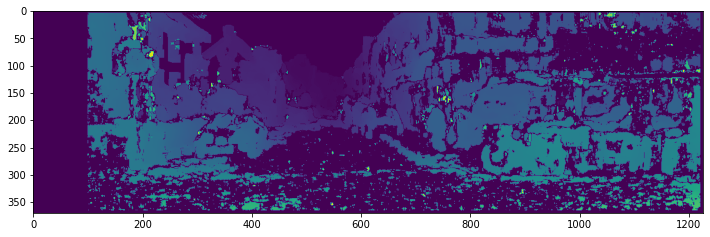

In [9]:
%matplotlib inline
l = cv2.imread(os.path.join(os.getenv("l_image_dir"), f"{'0'*10}.png"), 0)
r = cv2.imread(os.path.join(os.getenv("r_image_dir"), f"{'0'*10}.png"), 0)

disp = compute_disparity_map(l, r, verbose=True)
plt.figure(figsize=(12,6))
plt.imshow(disp)
plt.show()

Compute disparity map with stereoSGBM: 0.04202 secs


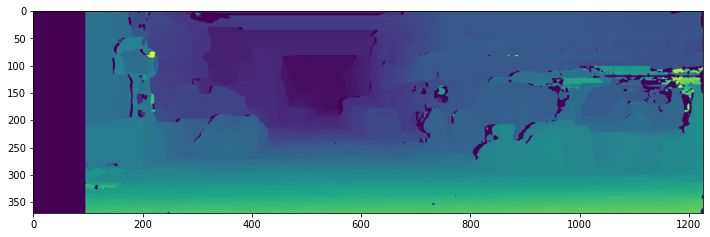

In [10]:
disp = compute_disparity_map(l, r, matcher='sgbm', verbose=True)
plt.figure(figsize=(12,6))
plt.imshow(disp)
plt.show()

In [11]:
def decompose_projecttion(P: np.ndarray) -> tuple:
    k, r, t, *_ = cv2.decomposeProjectionMatrix(P)
    t = (t / t[3])[:3]  # non-homogeneous
    return k, r, t


def depth_map(disp: np.ndarray, k: np.ndarray, tl: np.ndarray, tr: np.ndarray) -> np.ndarray:
    f = k[0, 0]
    b = tr[0] - tl[0]

    disp = np.where((disp == 0.0) | (disp == -1.0), 0.1, disp)
    depth = depth = (f * b) / disp

    return depth

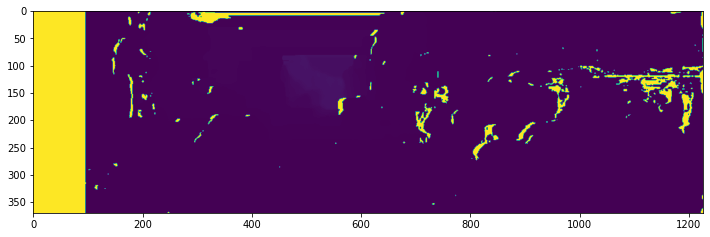

In [62]:
k0, r0, t0 = decompose_projecttion(p0)
k1, r1, t1 = decompose_projecttion(p1)

disp = compute_disparity_map(l, r, matcher='sgbm')
depth = depth_map(disp, k0, t0, t1)
plt.figure(figsize=(12, 6))
plt.imshow(depth)
plt.show()

## LiDAR Dataset Process
Process the LiDAR data from the dataset, which could be used for depth estimation and odometry correction later.

In [58]:
def pcl2img(pcl: np.ndarray, image: np.ndarray, Tr: np.ndarray, P0: np.ndarray) -> np.ndarray:
    ih, iw = image.shape[0], image.shape[1]

    pcl = pcl[pcl[:, 0] > 0] # ignore anything behind lidar
    pcl = np.hstack([pcl[:, :3], np.ones(pcl.shape[0]).reshape((-1, 1))])

    ## transform point cloud into camera coordiante and ignore point behind camera
    cam = Tr @ pcl.T
    cam = cam[:, cam[2] > 0]
    
    depth = cam[2].copy()
    cam /= cam[2]
    cam = np.vstack([cam, np.ones(cam.shape[1])])
    
    project = P0 @ cam
    pixel_coord = project.T.round(0)[:, :2].astype(np.int32)

    indices = np.where(
        (pixel_coord[:, 0] < iw) &
        (pixel_coord[:, 0] >= 0) &
        (pixel_coord[:, 1] < ih) &
        (pixel_coord[:, 1] >= 0)
    )
    pixel_coord = pixel_coord[indices]
    depth = depth[indices]

    depth_map = np.zeros((ih, iw))
    for i, (u, v) in enumerate(pixel_coord):
        if u < 0 or u >= iw or v < 0 or v > ih:
            continue

        depth_map[v, u] = depth[i]
    
    depth_map[depth_map == 0.0] = 3000

    return depth_map

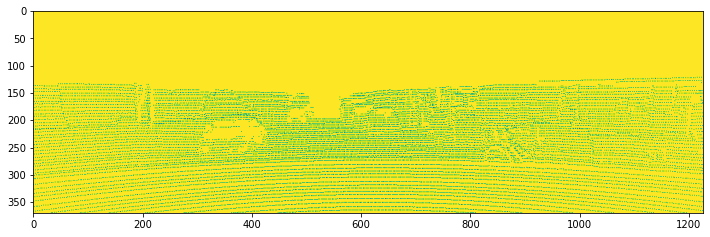

In [ ]:
pcl0 = np.fromfile(
    os.path.join(os.getenv("lidar_dir"), f"{'0'*10}.bin"), 
    dtype=np.float32, count=-1
).reshape((-1, 4))
tr: np.ndarray = np.array(calib.loc["Tr:"]).reshape((3, 4))

depth_from_lidar = pcl2img(pcl0, l, tr, p0)
plt.figure(figsize=(12, 6))
plt.imshow(depth_from_lidar)
plt.show()


In [68]:
coverage = (
    depth_from_lidar[depth_from_lidar < depth_from_lidar.max()].size
    / depth_from_lidar.size
)
print(f"LiDAR coverage: {coverage * 100:.2f}%.")

LiDAR coverage: 4.38%.


## Feature Extraction and Matching
Extract the feature from image and matching between each frame to find the transformation relationship in camera poses between a sequences of frames.

In [26]:
from typing import Optional


def extract(image: np.ndarray, detector: str = "sift") -> tuple:
    detectors = {"sift": cv2.SIFT_create, "orb": cv2.ORB_create}
    if detector not in detectors:
        raise ValueError("Detector must be 'sift' or 'orb'.")

    return detectors[detector]().detectAndCompute(image, None)


def matching(
    des1,
    des2,
    detector: str = "sift",
    matcher: str = "bf",
    sort: bool = True,
    filter_thres: Optional[float] = None,
) -> list[cv2.DMatch]:
    if detector not in ("sift", "orb"):
        raise ValueError("Detector must be 'sift' or 'orb'.")

    if matcher not in ("bf", "flann"):
        raise ValueError("Matcher must be 'bf' or 'flann'.")

    if matcher == "bf":
        _matcher = cv2.BFMatcher_create(
            cv2.NORM_L2 if detector == "sift" else cv2.NORM_HAMMING2, 
            crossCheck=False
        )
    else:
        _matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

    matches = _matcher.knnMatch(des1, des2, 2)
    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance)

    return [
        m
        for m, n in matches
        if filter_thres is None or m.distance <= filter_thres * n.distance
    ]


def visualize(
    image1: np.ndarray,
    kp1: list,
    image2: np.ndarray,
    kp2: list,
    matches: list,
) -> None:
    _image = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(_image)
    plt.show()

Number of matches with filtering: 866.


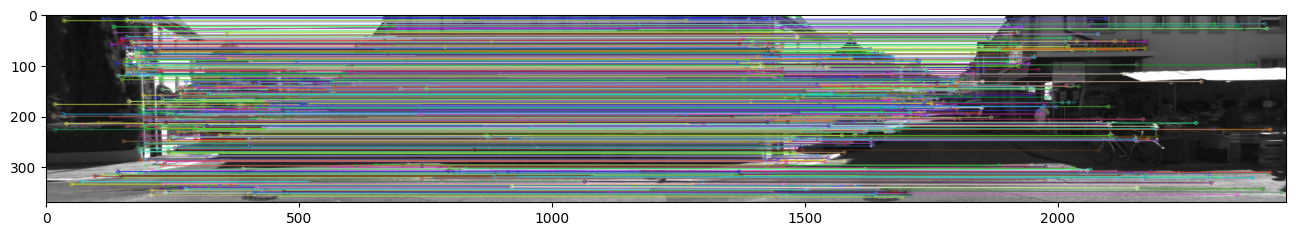

In [27]:
image1 = cv2.imread(os.path.join(os.getenv("l_image_dir"), f"{'0'*9}0.png"), 0)
image2 = cv2.imread(os.path.join(os.getenv("l_image_dir"), f"{'0'*9}1.png"), 0)

kp1, des1 = extract(image1)
kp2, des2 = extract(image2)
m = matching(des1, des2, matcher='bf', filter_thres=0.4)
print(f"Number of matches with filtering: {len(m)}.")
visualize(image1, kp1, image2, kp2, m)

Number of matches with filtering: 197.


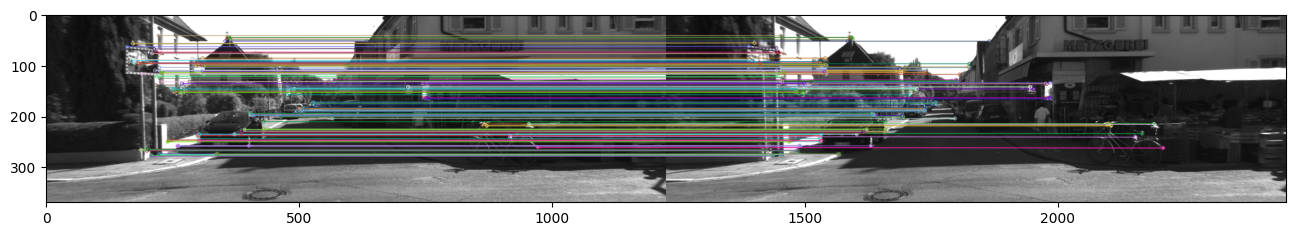

In [28]:
kp1, des1 = extract(image1, 'orb')
kp2, des2 = extract(image2, 'orb')
m = matching(des1, des2, detector='orb', matcher='bf', filter_thres=0.4)
print(f"Number of matches with filtering: {len(m)}.")
visualize(image1, kp1, image2, kp2, m)